## Initial Replication (i.e. using the same data Rameriez et al used.)

This notebook will get data and put it into the form needed for the project (ie a csv file) 
This first section will do so with the final.dta data from the github associated to betting on a buzz. Also included is the data which is collected by myself.

In [81]:
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [102]:
df = pd.read_stata("final.dta")



## Encode Tournaments

This is done for the OLS estimator, however the ols cannot deal with catagorical values so we encode each tournament as a natural number. E.g Brisbane International = 22

In [103]:
df["encoded_tournament"] = df.tournament.astype('category').cat.codes
df

,hot_raw,year,hotness_l,lastname_l,hotness_w,lastname_w,wta,location,tournament,tier,...,wiki_mean_player_l,wiki_med_player_l,wiki_yesterday_l,wiki_twodays_l,timezone,utc_offset,elopredict,elo_pi_hat,welo_pi_hat,encoded_tournament
0,41- Jarmila Groth,2011.0,NaN,Santonja,41.0,Groth,2.0,Brisbane,Brisbane International,International,...,NaN,NaN,NaN,NaN,Australia/Brisbane,10.0,0.637051,NaN,NaN,22
1,88- Arina Rodionova,2011.0,88.0,Rodionova,69.0,Jovanovski,2.0,Brisbane,Brisbane International,International,...,NaN,NaN,NaN,NaN,Australia/Brisbane,10.0,0.524215,NaN,NaN,22
2,72- Anastasia Pavlyuchenkova,2011.0,NaN,Kudryavtseva,72.0,Pavlyuchenkova,2.0,Brisbane,Brisbane International,International,...,NaN,NaN,NaN,NaN,Australia/Brisbane,10.0,0.710430,NaN,NaN,22
3,,2011.0,NaN,Kleybanova,NaN,Peers,2.0,Brisbane,Brisbane International,International,...,NaN,NaN,NaN,NaN,Australia/Brisbane,10.0,0.179002,NaN,NaN,22
4,66- Johanna Larsson,2011.0,66.0,Larsson,91.0,Peng,1.0,Auckland,ASB Classic,International,...,NaN,NaN,NaN,NaN,Pacific/Auckland,13.0,0.689614,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20260,6- Maria Sharapova,2019.0,NaN,Bacsinszky,6.0,Sharapova,3.0,Shenzhen,Shenzhen Open,International,...,263.967072,88.0,46.0,69.0,,NaN,NaN,NaN,NaN,99
20261,,2019.0,NaN,Voegele,NaN,Tormo,1.0,Auckland,ASB Classic,International,...,2.656930,2.0,0.0,2.0,,NaN,NaN,NaN,NaN,3
20262,19- Lesia Tsurenko,2019.0,NaN,Buzarnescu,19.0,Tsurenko,2.0,Brisbane,Brisbane International,Premier,...,3.589485,2.0,1.0,1.0,,NaN,NaN,NaN,NaN,22
20263,11- Donna Vekic,2019.0,NaN,Rybarikova,11.0,Vekic,2.0,Brisbane,Brisbane International,Premier,...,6.000531,3.0,1.0,7.0,,NaN,NaN,NaN,NaN,22


Data was downloaded from https://drive.google.com/drive/folders/1GiRMkek1MnUAYzIhutt_Oie_XIq2vDO7 (final.dta)
Now we needed to add the features needed within the program.

Need to add 

1) RankDist/RankDiff
2) WikiBuzz
3) Odds

In [84]:
df.columns


Index(['hot_raw', 'year', 'hotness_l', 'lastname_l', 'hotness_w', 'lastname_w',
       'wta', 'location', 'tournament', 'tier', 'court', 'surface', 'round',
       'bestof', 'winner', 'loser', 'wrank', 'lrank', 'wpts', 'lpts', 'w1',
       'l1', 'w2', 'l2', 'w3', 'l3', 'wsets', 'lsets', 'comment', 'b365w',
       'b365l', 'exw', 'exl', 'lbw', 'lbl', 'psw', 'psl', 'sjw', 'sjl', 'maxw',
       'maxl', 'avgw', 'avgl', 'date', 'month', 'day', 'odds_player', 'player',
       'wiki_w', 'pid', 'wiki_med30_w', 'wiki_med365_w', 'wiki_med7_w',
       'wiki_mean30_w', 'wiki_mean365_w', 'wiki_mean7_w', 'wiki_min30_w',
       'wiki_min365_w', 'wiki_min7_w', 'wiki_mean_player_w',
       'wiki_med_player_w', 'wiki_yesterday_w', 'wiki_twodays_w', 'wiki_l',
       'wiki_med30_l', 'wiki_med365_l', 'wiki_med7_l', 'wiki_mean30_l',
       'wiki_mean365_l', 'wiki_mean7_l', 'wiki_min30_l', 'wiki_min365_l',
       'wiki_min7_l', 'wiki_mean_player_l', 'wiki_med_player_l',
       'wiki_yesterday_l', 'wiki_twoda

## Match No.

In [85]:
df["match_id"] = df.index

## RankDiff

Very simple, calculates the difference between the winners rank and the losers rank and stores in two variables, wRankDiff and lRankDiff. Of note although they are both calculated wRankDiff = -lRankdiff

In [86]:
df["wRankDiff"] = df["wrank"] - df["lrank"] 
df["lRankDiff"] = df["lrank"] - df["wrank"]

## RankDist

This equation is a little more complicated being given by

 \\( RankDist(a,b,i) = -( \dfrac{1}{rank_{ai}} - \dfrac{1}{rank_{bi}})  \\)
 
 Of note if opponant a is unranked as of the time of the match i then 
 \\( \dfrac{1}{rank_{ai}} = 0  \\)

In [87]:
df["wrank"].isna().sum()

71

In [88]:
df["lrank"].isna().sum()

103

In [89]:
def RankDist(wrank,lrank):
    if math.isnan(wrank) == True:
        inv_wrank = 0
    else:
        inv_wrank = 1/wrank
    if math.isnan(lrank) == True:
        inv_lrank = 0
    else:
        inv_lrank = 1/lrank
    wrankdist = -(inv_wrank - inv_lrank)
    #lrankdist = -(inv_lrank - inv_wrank)
    return(wrankdist)#,lrankdist)

In [90]:
df["wrankdist"] = [RankDist(wrank,lrank) for wrank,lrank in zip(df["wrank"],df["lrank"])]
df["lrankdist"] = -df["wrankdist"]

## WikiBuzz

Calculated by \\(     WikiBuzz(a,b,i) = ln(w_{ai}/\tilde{w_{ai}}) - ln(w_{bi}/\tilde{w_{bi}}) \\)

In [91]:
def WikiBuzz(w_views,w_median_views,l_views,l_median_views):
    try:
        return(np.log(w_views/w_median_views) - np.log(l_views/l_median_views))
    except:
        return(None)
    

df["w_wikibuzz"] = [WikiBuzz(w_views,w_median_views,l_views,l_median_views) for w_views,w_median_views,l_views,l_median_views in zip(df["wiki_yesterday_w"],df["wiki_med365_w"],df["wiki_yesterday_l"],df["wiki_med365_l"])]
df["l_wikibuzz"] = [WikiBuzz(w_views,w_median_views,l_views,l_median_views) for w_views,w_median_views,l_views,l_median_views in zip(df["wiki_yesterday_l"],df["wiki_med365_l"],df["wiki_yesterday_w"],df["wiki_med365_w"])]

In [92]:
df["w_wikibuzz"].isna().sum()

9535

## Odds

In [93]:
df["inv_bet365w"] = 1/df["b365w"]
df["inv_bet365l"] = 1/df["b365l"]
df["inv_avgw"] = 1/df["avgw"]
df["inv_avgl"] = 1/df["avgl"]
df["inv_maxw"] = 1/df["maxw"]
df["inv_maxl"] = 1/df["maxl"]

In [94]:
df.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            20255, 20256, 20257, 20258, 20259, 20260, 20261, 20262, 20263,
            20264],
           dtype='int64', length=20265)

This is all good for now but is quite confusing to look at, overall want a df containing each match twice in regards to winner and losers

Next step is using OLS to calculate params 

So we need a column for win/lose and the associated variables, want a df with the following columns:

MatchID, Player, Date, Year, RankDist, WikiBuzz, inv_bet365, inv_avg, inv_max, Win

In [95]:
win_df = df[["match_id","winner","loser","year","month","day","wRankDiff","wrankdist","w_wikibuzz","inv_bet365w","inv_avgw","inv_maxw","encoded_tournament"]].copy()
win_df["win"] = 1
win_df = win_df.set_axis(["match_id","player","opponent","year","month","day","rankdiff","rankdist","wikibuzz","inv_bet365","inv_avg","inv_max","encoded_tournament","win"], axis=1)
win_df

,match_id,player,opponent,year,month,day,rankdiff,rankdist,wikibuzz,inv_bet365,inv_avg,inv_max,encoded_tournament,win
0,0,Groth J.,Parra Santonja A.,2011.0,1.0,2.0,-23.0,-0.008425,NaN,0.819672,0.800000,0.751880,22,1
1,1,Jovanovski B.,Rodionova A.,2011.0,1.0,2.0,12.0,0.002467,NaN,0.546448,0.546448,0.512820,22,1
2,2,Pavlyuchenkova A.,Kudryavtseva A.,2011.0,1.0,2.0,-39.0,-0.030952,NaN,0.781250,0.775194,0.740741,22,1
3,3,Peers S.,Kleybanova A.,2011.0,1.0,2.0,129.0,0.033506,NaN,0.125000,0.137363,0.100000,22,1
4,4,Peng S.,Larsson J.,2011.0,1.0,2.0,3.0,0.000604,NaN,0.666667,0.662252,0.617284,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20260,20260,Sharapova M.,Bacsinszky T.,2019.0,12.0,31.0,-162.0,-0.029247,0.275481,0.751880,0.740741,0.714286,99,1
20261,20261,Sorribes Tormo S.,Voegele S.,2019.0,12.0,31.0,3.0,0.000420,inf,0.444444,0.425532,0.305810,3,1
20262,20262,Tsurenko L.,Buzarnescu M.,2019.0,12.0,31.0,3.0,0.004630,0.562308,0.555556,0.529101,0.510204,22,1
20263,20263,Vekic D.,Rybarikova M.,2019.0,12.0,31.0,-14.0,-0.008578,0.587787,0.666667,0.645161,0.625000,22,1


In [96]:
loss_df = df[["match_id","loser","winner","year","month","day","lRankDiff","lrankdist","l_wikibuzz","inv_bet365l","inv_avgl","inv_maxl","encoded_tournament"]].copy()
loss_df["win"] = 0
loss_df = loss_df.set_axis(["match_id","player","opponent","year","month","day","rankdiff","rankdist","wikibuzz","inv_bet365","inv_avg","inv_max","encoded_tournament","win"], axis=1)
loss_df

,match_id,player,opponent,year,month,day,rankdiff,rankdist,wikibuzz,inv_bet365,inv_avg,inv_max,encoded_tournament,win
0,0,Parra Santonja A.,Groth J.,2011.0,1.0,2.0,23.0,0.008425,NaN,0.250000,0.262467,0.230415,22,0
1,1,Rodionova A.,Jovanovski B.,2011.0,1.0,2.0,-12.0,-0.002467,NaN,0.546448,0.523560,0.487805,22,0
2,2,Kudryavtseva A.,Pavlyuchenkova A.,2011.0,1.0,2.0,39.0,0.030952,NaN,0.285714,0.291545,0.257069,22,0
3,3,Kleybanova A.,Peers S.,2011.0,1.0,2.0,-129.0,-0.033506,NaN,0.943396,0.925926,0.909091,22,0
4,4,Larsson J.,Peng S.,2011.0,1.0,2.0,-3.0,-0.000604,NaN,0.400000,0.406504,0.357143,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20260,20260,Bacsinszky T.,Sharapova M.,2019.0,12.0,31.0,162.0,0.029247,-0.275481,0.307692,0.314465,0.294118,99,0
20261,20261,Voegele S.,Sorribes Tormo S.,2019.0,12.0,31.0,-3.0,-0.000420,-inf,0.636943,0.628931,0.606061,3,0
20262,20262,Buzarnescu M.,Tsurenko L.,2019.0,12.0,31.0,-3.0,-0.004630,-0.562308,0.526316,0.520833,0.490196,22,0
20263,20263,Rybarikova M.,Vekic D.,2019.0,12.0,31.0,14.0,0.008578,-0.587787,0.400000,0.403226,0.384615,22,0


In [97]:
final_df = pd.concat([win_df,loss_df])
final_df.sort_values(["match_id"])
#final_df.isna().sum()
final_df.replace([np.inf, -np.inf], np.nan, inplace=True)
print(final_df.isna().sum())
final_df = final_df.dropna(axis=0)
final_df.isna().sum()

match_id                  0
player                    0
opponent                  0
year                      0
month                     0
day                       0
rankdiff                230
rankdist                  0
wikibuzz              19466
inv_bet365              269
inv_avg                 180
inv_max                 181
encoded_tournament        0
win                       0
dtype: int64


match_id              0
player                0
opponent              0
year                  0
month                 0
day                   0
rankdiff              0
rankdist              0
wikibuzz              0
inv_bet365            0
inv_avg               0
inv_max               0
encoded_tournament    0
win                   0
dtype: int64

In [98]:
final_df.sort_values(by=["year","month","day"], inplace=True)
final_df

,match_id,player,opponent,year,month,day,rankdiff,rankdist,wikibuzz,inv_bet365,inv_avg,inv_max,encoded_tournament,win
12773,12773,Dellacqua C.,Svitolina E.,2015.0,7.0,2.0,44.0,0.042430,0.000000,0.546448,0.537634,0.518135,120,1
12774,12774,Giorgi C.,Arruabarrena L.,2015.0,7.0,2.0,-53.0,-0.019485,0.000000,0.900901,0.892857,0.877193,120,1
12775,12775,Govortsova O.,Cornet A.,2015.0,7.0,2.0,95.0,0.028840,0.000000,0.476191,0.465116,0.444444,120,1
12776,12776,Jankovic J.,Rodina E.,2015.0,7.0,2.0,-71.0,-0.023432,0.000000,0.819672,0.813008,0.793651,120,1
12777,12777,Kerber A.,Pavlyuchenkova A.,2015.0,7.0,2.0,-32.0,-0.076190,0.000000,0.862069,0.877193,0.847458,120,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4139,4139,Alexandrova E.,Bertens K.,2020.0,2.0,15.0,20.0,0.089286,1.323982,0.500000,0.483092,0.454545,70,0
4141,4141,Tig P.M.,Linette M.,2020.0,2.0,15.0,63.0,0.014286,-0.517943,0.381679,0.396825,0.378788,108,0
4142,4142,Sakkari M.,Rybakina E.,2020.0,2.0,15.0,-4.0,-0.007619,-1.612937,0.421941,0.431035,0.408163,70,0
4143,4143,Bertens K.,Rybakina E.,2020.0,2.0,16.0,-17.0,-0.085000,-2.935837,0.636943,0.641026,0.621118,70,1


In [19]:
final_df.loc[final_df["player"]=="Hercog P."]

,match_id,player,year,month,day,rankdiff,rankdist,wikibuzz,inv_bet365,inv_avg,inv_max,encoded_tournament,win
12821,12821,Hercog P.,2015.0,7.0,13.0,-7.0,-0.000856,-0.421213,0.636943,0.609756,0.588235,25,1
12878,12878,Hercog P.,2015.0,7.0,18.0,27.0,0.005172,2.222542,0.454545,0.454545,0.420168,25,0
12895,12895,Hercog P.,2015.0,7.0,21.0,-4.0,-0.000625,1.331235,0.694444,0.680272,0.662252,42,1
12912,12912,Hercog P.,2015.0,7.0,22.0,23.0,0.005361,1.400088,0.546448,0.523560,0.500000,42,1
12930,12930,Hercog P.,2015.0,7.0,24.0,35.0,0.010435,-1.039144,0.581395,0.555556,0.497512,42,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19922,19922,Hercog P.,2019.0,10.0,8.0,27.0,0.026786,1.516656,0.381679,0.386100,0.353357,43,0
19974,19974,Hercog P.,2019.0,10.0,15.0,-11.0,-0.003741,0.130206,0.454545,0.452489,0.429185,66,1
19988,19988,Hercog P.,2019.0,10.0,16.0,39.0,0.079592,1.546922,0.363636,0.358423,0.333333,66,0
2448,2448,Hercog P.,2020.0,1.0,21.0,4.0,0.001894,-0.355699,0.434783,0.431035,0.413223,9,1


## Replication

First create the train/test datasets

In [99]:
train_data = final_df[final_df['year'] < 2019]
test_data =final_df[final_df['year'] >= 2019]

In [101]:
final_df.to_csv("final.csv")
train_data.to_csv("train.csv")
test_data.to_csv("test.csv")

In [59]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [106]:
test_data.loc[test_data["player"]=="Hercog P."]

,match_id,player,opponent,year,month,day,rankdiff,rankdist,wikibuzz,inv_bet365,inv_avg,inv_max,encoded_tournament,win
1977,1977,Hercog P.,Hsieh S.W.,2019.0,1.0,1.0,57.0,0.023950,-0.310155,0.400000,0.406504,0.380228,3,0
2106,2106,Hercog P.,Kerber A.,2019.0,1.0,14.0,90.0,0.489130,1.264116,0.111111,0.096246,0.071891,9,0
3957,3957,Hercog P.,Riske A.,2019.0,2.0,12.0,36.0,0.007867,1.270005,0.294118,0.312500,0.285714,92,0
4001,4001,Hercog P.,Voegele S.,2019.0,2.0,18.0,5.0,0.000685,-1.025281,0.546448,0.512820,0.495050,35,0
5883,5883,Hercog P.,Doi M.,2019.0,3.0,23.0,-19.0,-0.001824,-1.707411,0.181818,0.540541,0.476191,101,1
5891,5891,Hercog P.,Halep S.,2019.0,3.0,24.0,90.0,0.322581,2.759176,0.111111,0.114679,0.090909,101,0
7541,7541,Hercog P.,Suarez Navarro C.,2019.0,4.0,9.0,62.0,0.025801,0.202266,0.381679,0.386100,0.352113,97,1
7556,7556,Hercog P.,Cirstea S.,2019.0,4.0,10.0,-14.0,-0.001527,1.922078,0.653595,0.621118,0.588235,97,1
7578,7578,Hercog P.,Kudermetova V.,2019.0,4.0,12.0,6.0,0.000812,-0.956752,0.636943,0.617284,0.595238,97,1
7583,7583,Hercog P.,Ferro F.,2019.0,4.0,13.0,-19.0,-0.001977,-0.753439,0.621118,0.617284,0.581395,97,1


# Need to use OLS to calculate the following: Eq.1

\\( e(a,b,i) = \alpha + \beta_1 z_(a,b,i) + \beta_2 RankDist(a,b,i) + \beta_3 WikiBuzz(a,b,i) + \psi S(a,b,i) +\phi T(a,b,i) + \epsilon(a,b,i) \\)
    
Where Psi represents the season and Phi represents the Tournament and epsilon is noise

In [107]:
#X = train_data[["inv_bet365", "rankdist","wikibuzz"]]
#y = train_data["win"] 
#X = sm.add_constant(X) 
#est = sm.OLS(y, X).fit() 
#print(est.params)

#function to estimate eq.1 by OLS. can get rid of rankdist or wikibuzz factors easily, returns paramters
def OLS_Params(odds,rankdist = True, wikibuzz = True,year = True,tournament = True): 
    data_params = [odds]
    if rankdist:
        data_params.append("rankdist")
    if wikibuzz:
        data_params.append("wikibuzz")
    if year:
        data_params.append("year")
    if tournament:
        data_params.append("encoded_tournament")
    X = train_data[data_params]
    y = train_data["win"] 
    X = sm.add_constant(X) 
    model = sm.OLS(y, X)
    results = model.fit()
  #  output = est.params
    const = results.params.const
    odds = results.params[1]
    print(results.params)
    if wikibuzz == False: 
         wikibuzz = 0 
    elif wikibuzz == True:
        wikibuzz = results.params.wikibuzz
    if rankdist == False: 
         rankdist = 0
    elif rankdist == True:
        rankdist = results.params.rankdist
    if year == False:
        year = 0
    elif year == True:
        year = results.params.year
    if tournament == False:
        tournament = 0
    elif tournament == True:
        tournament = results.params.encoded_tournament   
    output = [const,odds,rankdist,wikibuzz,year,tournament]
    return(output)

def OLS_rankdiff_Params(odds,rankdist = True, wikibuzz = True,year = True,tournament = True): 
    data_params = [odds]
    if rankdist:
        data_params.append("rankdiff")
    if wikibuzz:
        data_params.append("wikibuzz")
    if year:
        data_params.append("year")
    if tournament:
        data_params.append("encoded_tournament")
    X = train_data[data_params]
    y = train_data["win"] 
    X = sm.add_constant(X) 
    model = sm.OLS(y, X)
    results = model.fit()
  #  output = est.params
    const = results.params.const
    odds = results.params[1]
    print(results.params)
    if wikibuzz == False: 
         wikibuzz = 0 
    elif wikibuzz == True:
        wikibuzz = results.params.wikibuzz
    if rankdist == False: 
         rankdist = 0
    elif rankdist == True:
        rankdist = results.params.rankdiff
    if year == False:
        year = 0
    elif year == True:
        year = results.params.year
    if tournament == False:
        tournament = 0
    elif tournament == True:
        tournament = results.params.encoded_tournament   
    output = [const,odds,rankdist,wikibuzz,year,tournament]
    return(output)
    
        

In [25]:
from linearmodels import PanelOLS

In [108]:
train_data

,match_id,player,opponent,year,month,day,rankdiff,rankdist,wikibuzz,inv_bet365,inv_avg,inv_max,encoded_tournament,win
12773,12773,Dellacqua C.,Svitolina E.,2015.0,7.0,2.0,44.0,0.042430,0.000000,0.546448,0.537634,0.518135,120,1
12774,12774,Giorgi C.,Arruabarrena L.,2015.0,7.0,2.0,-53.0,-0.019485,0.000000,0.900901,0.892857,0.877193,120,1
12775,12775,Govortsova O.,Cornet A.,2015.0,7.0,2.0,95.0,0.028840,0.000000,0.476191,0.465116,0.444444,120,1
12776,12776,Jankovic J.,Rodina E.,2015.0,7.0,2.0,-71.0,-0.023432,0.000000,0.819672,0.813008,0.793651,120,1
12777,12777,Kerber A.,Pavlyuchenkova A.,2015.0,7.0,2.0,-32.0,-0.076190,0.000000,0.862069,0.877193,0.847458,120,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20232,20232,Wang Q.,Riske A.,2018.0,12.0,31.0,-25.0,-0.007937,-1.057593,0.666667,0.666667,0.628931,99,0
20233,20233,Niculescu M.,Sabalenka A.,2018.0,12.0,31.0,6.0,0.001040,-0.179158,0.444444,0.458716,0.361011,99,0
20234,20234,Stosur S.,Sevastova A.,2018.0,12.0,31.0,25.0,0.038110,0.824421,0.400000,0.396825,0.377358,22,0
20235,20235,Jabeur O.,Siniakova K.,2018.0,12.0,31.0,42.0,0.010041,0.205852,0.381679,0.392157,0.359712,99,0


In [109]:
train_data = train_data.set_index(['match_id'], append=True)

In [110]:
from linearmodels.panel import PanelOLS
# Model
#train_data=train_data.set_index("match_id", append=True)
exog_vars = train_data[["inv_avg","rankdist"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit(cov_type='clustered', cluster_entity=True)
results

Dep. Variable:,win,R-squared:,0.1580
Estimator:,PanelOLS,R-squared (Between):,-0.4681
No. Observations:,15801,R-squared (Within):,0.1580
Date:,"Thu, Aug 03 2023",R-squared (Overall):,0.1580
Time:,10:37:46,Log-likelihood,-1.011e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,1481.7
Entities:,7901,P-value,0.0000
Avg Obs:,1.9999,Distribution:,"F(2,15795)"
Min Obs:,1.0000,,
Max Obs:,2.0000,F-statistic (robust):,969.11


In [29]:
x = OLS_Params("inv_avg",rankdist = True, wikibuzz = False,year = True,tournament = False) 

const      -3.058055
inv_avg     1.001490
rankdist    0.060097
year        0.001502
dtype: float64


## Probability

calculated through 

\\( \tilde{y}(a,b,i) = \hat{\alpha} + (1 + \hat{\beta_1})z_{a,b,i} + \hat{\beta_2} RankDist(a,b,i) + \hat{\beta_3} WikiBuzz(a,b,i) \\)


In [111]:
def probability(const_p,odds_p,rankdist_p,wikibuzz_p,year_p,tournament_p,odds,rankdist,wikibuzz): #to be used in conjuncture with a df
    return(const_p + (odds_p)*odds + rankdist_p*rankdist + wikibuzz_p*wikibuzz)

#def no_rd_probability(OLS_Params,odds,rankdist,wikibuzz): #to be used in conjuncture with a df
 #   return(OLS_Params.const + (1+OLS_Params.inv_avg)*odds)

## Kelly Criterion 

   \\( x(a,b,i) = max\{ \hat{y_{a,b,i}} - \dfrac{1-\hat{y_{a,b,i}}}{o_{a,b,i} - 1},0\} \\)

In [112]:
def kelly_crit(probability,inv_odds):
               return(max((probability-((1-probability)/((1/inv_odds) - 1)),0)))


## Returns

In [113]:
def profit(kelly,inv_odds,win):
    decimal_odds = 1/inv_odds
    if win == 1: #match won
        return(kelly*decimal_odds - kelly) #profits - inital investment
    elif win == 0: #match lost
        return(-kelly) # - initial investment

## Replication of Table 1

Column I

In [33]:
exog_vars = train_data["inv_avg"]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
results.params

const     -0.016450
inv_avg    0.977647
Name: parameter, dtype: float64

Column II

In [34]:
exog_vars = train_data[["inv_avg","rankdiff"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
results.params

const       0.004237
inv_avg     0.938483
rankdiff   -0.000127
Name: parameter, dtype: float64

Column III

In [35]:
exog_vars = train_data[["inv_avg","rankdist"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
results.params

const      -0.029048
inv_avg     1.001497
rankdist    0.060101
Name: parameter, dtype: float64

Column IV

In [36]:
exog_vars = train_data[["inv_avg","rankdist","wikibuzz"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
results.params

const      -0.041449
inv_avg     1.024974
rankdist    0.053794
wikibuzz    0.009127
Name: parameter, dtype: float64

Column V

In [37]:
exog_vars = train_data[["inv_avg","rankdist","wikibuzz"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["encoded_tournament"])
results = model.fit()
x = results.params
x

const      -0.041422
inv_avg     1.024922
rankdist    0.053771
wikibuzz    0.009125
Name: parameter, dtype: float64

## Table 4

Column I


no of bets: 224
profit: -0.2787208441582934
Mean overround (%): 5.332310834271392
count    5131.000000
mean       -0.000054
std         0.006330
min        -0.064156
25%         0.000000
50%        -0.000000
75%         0.000000
max         0.139214
Name: profit, dtype: float64
ROI (%): -6.524094551774051


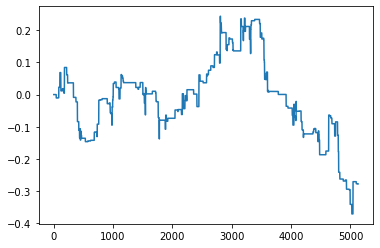

In [114]:
exog_vars = train_data[["inv_avg","rankdist","wikibuzz"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
x = results.params
test_data["avg_prob"] = [probability(x["const"],x["inv_avg"],x["rankdist"],x["wikibuzz"],0,0,odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_avg"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_avg"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((5160*test_data["profit"].mean())))
print("Mean overround (%): "+str((test_data.sort_values(by="match_id")["inv_avg"].rolling(2).sum()[1::2].mean()-1)*100))
plt.plot(list(test_data["profit"].cumsum()))
print(test_data["profit"].describe())
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))

Column II


no of bets: 2313
profit: 1.8192773298565015
Mean overround (%): -0.2098993488782508
count    5131.000000
mean        0.000353
std         0.032245
min        -0.220113
25%         0.000000
50%         0.000000
75%         0.000000
max         0.430440
Name: profit, dtype: float64
ROI (%): 2.4178613140017013


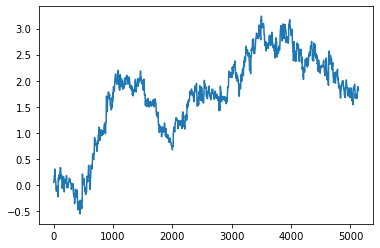

In [115]:
exog_vars = train_data[["inv_avg","rankdist","wikibuzz"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
x = results.params
test_data["avg_prob"] = [probability(x["const"],x["inv_avg"],x["rankdist"],x["wikibuzz"],0,0,odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_max"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_max"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((5160*test_data["profit"].mean())))
print("Mean overround (%): "+str((test_data.sort_values(by="match_id")["inv_max"].rolling(2).sum()[1::2].mean()-1)*100))
plt.plot(list(test_data["profit"].cumsum()))
print(test_data["profit"].describe())
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))

Column III


no of bets: 312
profit: 1.2578711624120453
Mean overround (%): 6.456107493729624
count    5131.000000
mean        0.000244
std         0.025713
min        -0.075763
25%         0.000000
50%         0.000000
75%         0.000000
max         1.732999
Name: profit, dtype: float64
ROI (%): 17.5736988554688


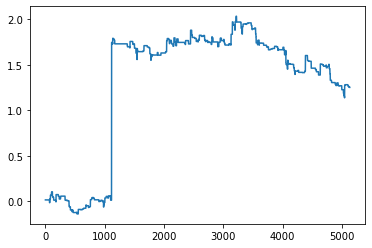

In [116]:
exog_vars = train_data[["inv_avg","rankdist","wikibuzz"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
x = results.params
test_data["avg_prob"] = [probability(x["const"],x["inv_avg"],x["rankdist"],x["wikibuzz"],0,0,odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_bet365"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_bet365"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((5160*test_data["profit"].mean())))
print("Mean overround (%): "+str((test_data.sort_values(by="match_id")["inv_bet365"].rolling(2).sum()[1::2].mean()-1)*100))
plt.plot(list(test_data["profit"].cumsum()))
print(test_data["profit"].describe())
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))

Column IV


no of bets: 274
profit: 1.4665685233498649
Mean overround (%): 6.456107493729624
count    5131.000000
mean        0.000284
std         0.024910
min        -0.065661
25%         0.000000
50%         0.000000
75%        -0.000000
max         1.726813
Name: profit, dtype: float64
ROI (%): 28.954512502983732


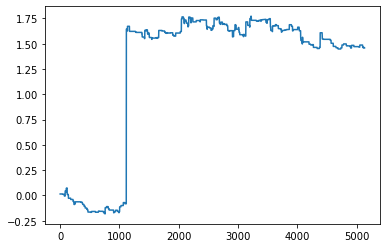

In [117]:
exog_vars = train_data[["inv_avg","wikibuzz"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
x = results.params
test_data["avg_prob"] = [probability(x["const"],x["inv_avg"],0,x["wikibuzz"],0,0,odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_bet365"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_bet365"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((5160*test_data["profit"].mean())))
print("Mean overround (%): "+str((test_data.sort_values(by="match_id")["inv_bet365"].rolling(2).sum()[1::2].mean()-1)*100))
plt.plot(list(test_data["profit"].cumsum()))
print(test_data["profit"].describe())
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))

## Hercog Removal

In [66]:
hercog_df = df.loc[df["match_id"]==5883]
print(hercog_df["b365w"],hercog_df["avgw"],)

5883    5.5
Name: b365w, dtype: float32 5883    1.85
Name: avgw, dtype: float32


In [67]:
test_data.loc[test_data["match_id"]==5883]

,Unnamed: 0,match_id,player,year,month,day,rankdiff,rankdist,wikibuzz,inv_bet365,inv_avg,inv_max,encoded_tournament,win,avg_prob,kelly,profit
1115,5883,5883,Hercog P.,2019.0,3.0,23.0,-19.0,-0.001824,-1.707411,0.181818,0.540540,0.476191,101,1,0.495784,0.383736,1.726813
1127,5883,5883,Doi M.,2019.0,3.0,23.0,19.0,0.001824,1.707411,0.877193,0.495049,0.421941,101,0,0.483182,0.000000,-0.000000


In [68]:
test_data["kelly"].describe()

count    5131.000000
mean        0.000982
std         0.008479
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.383736
Name: kelly, dtype: float64

In [69]:
test_data["profit"].describe()

count    5131.000000
mean        0.000284
std         0.024910
min        -0.065661
25%         0.000000
50%         0.000000
75%        -0.000000
max         1.726813
Name: profit, dtype: float64

In [70]:
test_data = test_data.drop(1115, axis = 0)
test_data

,Unnamed: 0,match_id,player,year,month,day,rankdiff,rankdist,wikibuzz,inv_bet365,inv_avg,inv_max,encoded_tournament,win,avg_prob,kelly,profit
0,1971,1971,Andreescu B.,2019.0,1.0,1.0,93.0,0.010370,2.667713,0.581395,0.591716,0.561798,3,1,0.589673,0.019774,0.014237
1,1972,1972,Anisimova A.,2019.0,1.0,1.0,-92.0,-0.005098,-0.693147,0.694444,0.657895,0.621118,3,1,0.623595,0.000000,0.000000
2,1974,1974,Cirstea S.,2019.0,1.0,1.0,28.0,0.005952,-0.031416,0.602410,0.617284,0.588235,99,1,0.589190,0.000000,0.000000
3,1976,1976,Goerges J.,2019.0,1.0,1.0,-61.0,-0.058095,-0.530628,0.833333,0.847458,0.819672,3,1,0.815732,0.000000,0.000000
4,1977,1977,Hsieh S.W.,2019.0,1.0,1.0,-57.0,-0.023950,0.310155,0.666667,0.645161,0.613497,3,1,0.620528,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5126,4139,4139,Alexandrova E.,2020.0,2.0,15.0,20.0,0.089286,1.323982,0.500000,0.483092,0.454545,70,0,0.467442,0.000000,-0.000000
5127,4141,4141,Tig P.M.,2020.0,2.0,15.0,63.0,0.014286,-0.517943,0.381679,0.396825,0.378788,108,0,0.362853,0.000000,-0.000000
5128,4142,4142,Sakkari M.,2020.0,2.0,15.0,-4.0,-0.007619,-1.612937,0.421941,0.431035,0.408163,70,0,0.386619,0.000000,-0.000000
5129,4143,4143,Bertens K.,2020.0,2.0,16.0,-17.0,-0.085000,-2.935837,0.636943,0.641026,0.621118,70,1,0.584881,0.000000,0.000000


## Col I


no of bets: 224
profit: -0.27877518357985864
Mean overround (%): 5.337940077856573
count    5130.000000
mean       -0.000054
std         0.006331
min        -0.064156
25%         0.000000
50%        -0.000000
75%         0.000000
max         0.139214
Name: profit, dtype: float64
ROI (%): -6.524094386219126


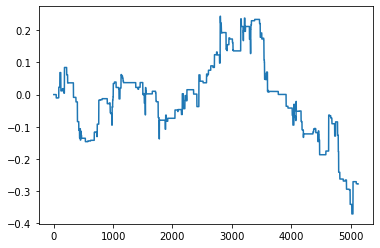

In [76]:
exog_vars = train_data[["inv_avg","rankdist","wikibuzz"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
x = results.params
test_data["avg_prob"] = [probability(x["const"],x["inv_avg"],x["rankdist"],x["wikibuzz"],0,0,odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_avg"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_avg"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((5160*test_data["profit"].mean())))
print("Mean overround (%): "+str((test_data.sort_values(by="match_id")["inv_avg"].rolling(2).sum()[1::2].mean()-1)*100))
plt.plot(list(test_data["profit"].cumsum()))
print(test_data["profit"].describe())
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))


no of bets: 2312
profit: 1.775868288557629
Mean overround (%): -0.2031484663928551
count    5130.000000
mean        0.000344
std         0.032243
min        -0.220113
25%         0.000000
50%         0.000000
75%        -0.000000
max         0.430440
Name: profit, dtype: float64
ROI (%): 2.3609579009739923


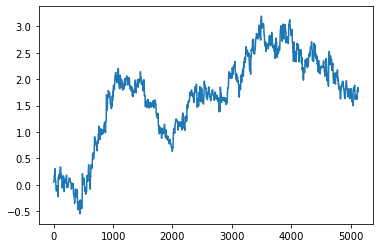

In [77]:
exog_vars = train_data[["inv_avg","rankdist","wikibuzz"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
x = results.params
test_data["avg_prob"] = [probability(x["const"],x["inv_avg"],x["rankdist"],x["wikibuzz"],0,0,odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_max"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_max"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((5160*test_data["profit"].mean())))
print("Mean overround (%): "+str((test_data.sort_values(by="match_id")["inv_max"].rolling(2).sum()[1::2].mean()-1)*100))
plt.plot(list(test_data["profit"].cumsum()))
print(test_data["profit"].describe())
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))


no of bets: 311
profit: -0.48501778648987715
Mean overround (%): 6.4760923789475955
count    5130.000000
mean       -0.000094
std         0.008706
min        -0.075763
25%         0.000000
50%         0.000000
75%         0.000000
max         0.171255
Name: profit, dtype: float64
ROI (%): -7.162395265800569


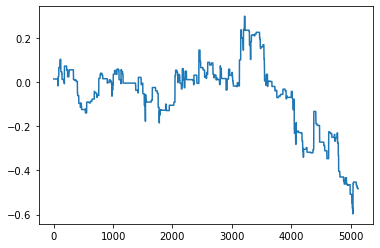

In [79]:
exog_vars = train_data[["inv_avg","rankdist","wikibuzz"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
x = results.params
test_data["avg_prob"] = [probability(x["const"],x["inv_avg"],x["rankdist"],x["wikibuzz"],0,0,odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_bet365"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_bet365"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((5160*test_data["profit"].mean())))
print("Mean overround (%): "+str((test_data.sort_values(by="match_id")["inv_bet365"].rolling(2).sum()[1::2].mean()-1)*100))
plt.plot(list(test_data["profit"].cumsum()))
print(test_data["profit"].describe())
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))


no of bets: 273
profit: -0.27005765151406
Mean overround (%): 6.4760923789475955
count    5130.000000
mean       -0.000052
std         0.006273
min        -0.065661
25%         0.000000
50%         0.000000
75%        -0.000000
max         0.145356
Name: profit, dtype: float64
ROI (%): -5.770356890986483


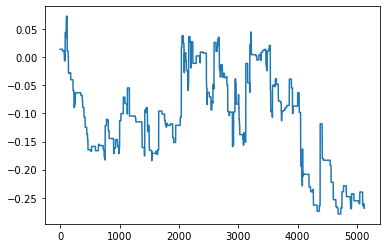

In [80]:
exog_vars = train_data[["inv_avg","wikibuzz"]]
exog = sm.add_constant(exog_vars)
model = PanelOLS(train_data["win"],exog,entity_effects=False,other_effects=train_data["year"])
results = model.fit()
x = results.params
test_data["avg_prob"] = [probability(x["const"],x["inv_avg"],0,x["wikibuzz"],0,0,odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_bet365"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_bet365"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((5160*test_data["profit"].mean())))
print("Mean overround (%): "+str((test_data.sort_values(by="match_id")["inv_bet365"].rolling(2).sum()[1::2].mean()-1)*100))
plt.plot(list(test_data["profit"].cumsum()))
print(test_data["profit"].describe())
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))

## Model Results  (IGNORE)

Replication of table 1

const      -0.030634
inv_avg     1.004501
wikibuzz    0.009546
dtype: float64
[-0.030633781646175876, 1.0045013066639936, 0, 0.009545923411189478, 0, 0]

no of bets: 144
profit: -0.1315513750426995
count    5155.000000
mean       -0.000025
std         0.003237
min        -0.059579
25%        -0.000000
50%        -0.000000
75%         0.000000
max         0.071646
Name: profit, dtype: float64
ROI (%): -6.204246850185358


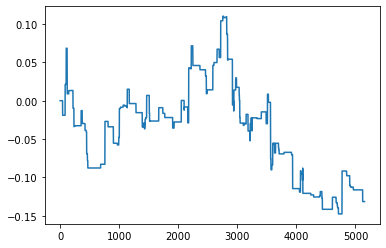

In [159]:
x = OLS_Params("inv_avg",rankdist = False, wikibuzz = True,year = False,tournament = False)
print(x)
test_data["avg_prob"] = [probability(x[0],x[1],x[2],x[3],x[4],x[5],odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
#train_data["avg_prob"] = [probability(x,a[0],a[1],a[2]) for a in zip(train_data["inv_avg"],train_data["rankdist"],train_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_avg"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_avg"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((5160*test_data["profit"].mean())))
plt.plot(list(test_data["profit"].cumsum()))
print(test_data["profit"].describe())
#print(test_data["avg_prob"].describe())
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))

const      -0.040947
inv_avg     1.024026
rankdist    0.053503
wikibuzz    0.008974
dtype: float64
[-0.040946947964167354, 1.0240257348645048, 0.05350320844365371, 0.008974466929935868, 0, 0]

no of bets: 2319
profit: 1.8241721274707678
count    5155.000000
mean        0.000354
std         0.032007
min        -0.219876
25%         0.000000
50%         0.000000
75%         0.000000
max         0.430300
Name: profit, dtype: float64
ROI (%): 2.4602089261097193


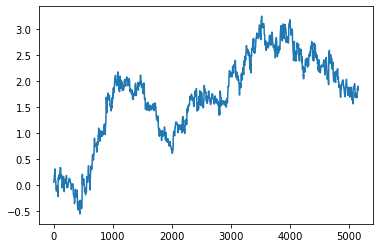

In [160]:
x = OLS_Params("inv_avg",rankdist = True, wikibuzz = True,year = False,tournament = False)
print(x)
test_data["avg_prob"] = [probability(x[0],x[1],x[2],x[3],x[4],x[5],odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
#train_data["avg_prob"] = [probability(x,a[0],a[1],a[2]) for a in zip(train_data["inv_avg"],train_data["rankdist"],train_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_max"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_max"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((5160*test_data["profit"].mean())))
plt.plot(list(test_data["profit"].cumsum()))
print(test_data["profit"].describe())
#print(test_data["avg_prob"].describe())
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))

const      -0.040947
inv_avg     1.024026
rankdist    0.053503
wikibuzz    0.008974
dtype: float64
[-0.040946947964167354, 1.0240257348645048, 0.05350320844365371, 0.008974466929935868, 0, 0]

no of bets: 309
profit: 1.237402716700858
ROI (%): 17.798828101972553


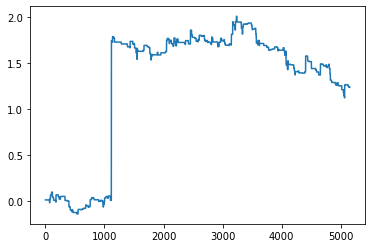

In [163]:
x = OLS_Params("inv_avg",rankdist = True, wikibuzz = True,year = False,tournament = False)
print(x)
test_data["avg_prob"] = [probability(x[0],x[1],x[2],x[3],x[4],x[5],odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
#train_data["avg_prob"] = [probability(x,a[0],a[1],a[2]) for a in zip(train_data["inv_avg"],train_data["rankdist"],train_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_bet365"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_bet365"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((5160*test_data["profit"].mean())))
plt.plot(list(test_data["profit"].cumsum()))
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))

const      -0.030634
inv_avg     1.004501
wikibuzz    0.009546
dtype: float64
[-0.030633781646175876, 1.0045013066639936, 0, 0.009545923411189478, 0, 0]

no of bets: 271
profit: 1.4370899436643279
count    5155.000000
mean        0.000279
std         0.024842
min        -0.064808
25%         0.000000
50%         0.000000
75%         0.000000
max         1.728226
Name: profit, dtype: float64
ROI (%): 29.49082122941631


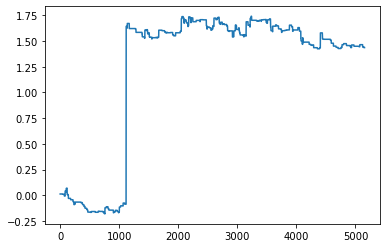

In [164]:
x = OLS_Params("inv_avg",rankdist = False, wikibuzz = True,year = False,tournament = False)
print(x)
test_data["avg_prob"] = [probability(x[0],x[1],x[2],x[3],x[4],x[5],odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
#train_data["avg_prob"] = [probability(x,a[0],a[1],a[2]) for a in zip(train_data["inv_avg"],train_data["rankdist"],train_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_bet365"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_bet365"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((5160*test_data["profit"].mean())))
plt.plot(list(test_data["profit"].cumsum()))
print(test_data["profit"].describe())
#print(test_data["avg_prob"].describe())
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))

In [1]:
test_data.sort_values("profit") ##Hercog!! Way too high

NameError: name 'test_data' is not defined

In [172]:
test_data = test_data.drop(5883, axis = 0)

const      -0.040947
inv_avg     1.024026
rankdist    0.053503
wikibuzz    0.008974
dtype: float64
[-0.040946947964167354, 1.0240257348645048, 0.05350320844365371, 0.008974466929935868, 0, 0]

no of bets: 2317
profit: 1.8838142625583958
count    5153.000000
mean        0.000365
std         0.031975
min        -0.219876
25%         0.000000
50%         0.000000
75%         0.000000
max         0.430300
Name: profit, dtype: float64
ROI (%): 2.544570402968538


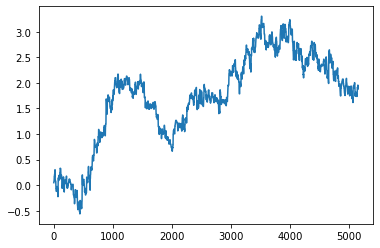

In [173]:
x = OLS_Params("inv_avg",rankdist = True, wikibuzz = True,year = False,tournament = False)
print(x)
test_data["avg_prob"] = [probability(x[0],x[1],x[2],x[3],x[4],x[5],odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
#train_data["avg_prob"] = [probability(x,a[0],a[1],a[2]) for a in zip(train_data["inv_avg"],train_data["rankdist"],train_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_max"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_max"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((5160*test_data["profit"].mean())))
plt.plot(list(test_data["profit"].cumsum()))
print(test_data["profit"].describe())
#print(test_data["avg_prob"].describe())
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))

const      -0.040947
inv_avg     1.024026
rankdist    0.053503
wikibuzz    0.008974
dtype: float64
[-0.040946947964167354, 1.0240257348645048, 0.05350320844365371, 0.008974466929935868, 0, 0]

no of bets: 308
profit: -0.4988515971502887
ROI (%): -7.594123982656953


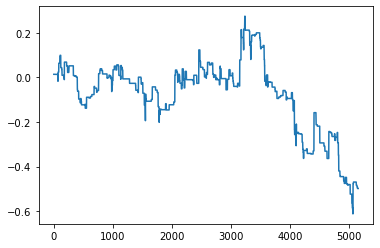

In [174]:
x = OLS_Params("inv_avg",rankdist = True, wikibuzz = True,year = False,tournament = False)
print(x)
test_data["avg_prob"] = [probability(x[0],x[1],x[2],x[3],x[4],x[5],odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
#train_data["avg_prob"] = [probability(x,a[0],a[1],a[2]) for a in zip(train_data["inv_avg"],train_data["rankdist"],train_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_bet365"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_bet365"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((5160*test_data["profit"].mean())))
plt.plot(list(test_data["profit"].cumsum()))
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))

const      -0.030634
inv_avg     1.004501
wikibuzz    0.009546
dtype: float64
[-0.030633781646175876, 1.0045013066639936, 0, 0.009545923411189478, 0, 0]

no of bets: 270
profit: -0.2929256958235393
count    5153.000000
mean       -0.000057
std         0.006143
min        -0.064808
25%         0.000000
50%         0.000000
75%        -0.000000
max         0.144899
Name: profit, dtype: float64
ROI (%): -6.52348250798852


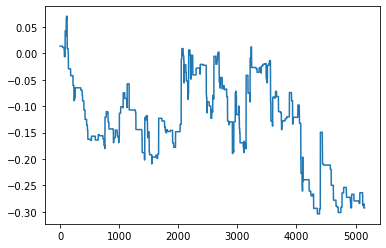

In [176]:
x = OLS_Params("inv_avg",rankdist = False, wikibuzz = True,year = False,tournament = False)
print(x)
test_data["avg_prob"] = [probability(x[0],x[1],x[2],x[3],x[4],x[5],odds,rankdist,wikibuzz) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
#train_data["avg_prob"] = [probability(x,a[0],a[1],a[2]) for a in zip(train_data["inv_avg"],train_data["rankdist"],train_data["wikibuzz"])]
test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data["inv_bet365"])]
test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data["inv_bet365"],test_data["win"])]
test_data["profit"].describe()
print()
print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
print("profit: " + str((5160*test_data["profit"].mean())))
plt.plot(list(test_data["profit"].cumsum()))
print(test_data["profit"].describe())
#print(test_data["avg_prob"].describe())
print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))